In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### Reading the dataset

In [100]:
passwords_data = pd.read_csv('new_password_data.csv')
passwords_data.drop(columns=['strength'], inplace=True)
passwords_data.head()

,password,new_strength
0,kzde5577,0
1,kino3434,0
2,visi7k1yr,0
3,megzy123,0
4,lamborghin1,1


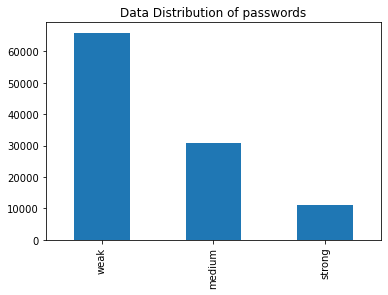

In [4]:
passwords_data['new_strength'].value_counts().plot(kind='bar')
plt.title('Data Distribution of passwords')
plt.xticks(np.arange(3), ['weak', 'medium', 'strong'])
plt.show()

# most of the passwords are medium

### Some passwords from each category

In [102]:
for i in range(3) :
    print(passwords_data[passwords_data['new_strength'] == i].head(2))
    print('-'*30)

   password  new_strength
0  kzde5577             0
1  kino3434             0
------------------------------
       password  new_strength
4   lamborghin1             1
8  universe2908             1
------------------------------
            password  new_strength
5   AVYq1lDE4MgAZfNt             2
13  WUt9IZzE0OQ7PkNE             2
------------------------------


### Splitting the data into train test split

In [6]:

X_train, X_test, y_train, y_test = train_test_split(passwords_data['password'], passwords_data['new_strength'], test_size=0.3, random_state=42, stratify=passwords_data['new_strength'])



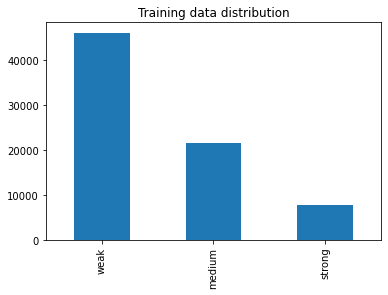

In [7]:
y_train.value_counts().plot(kind='bar')
plt.title('Training data distribution')
plt.xticks(np.arange(3), ['weak', 'medium', 'strong'])
plt.show()

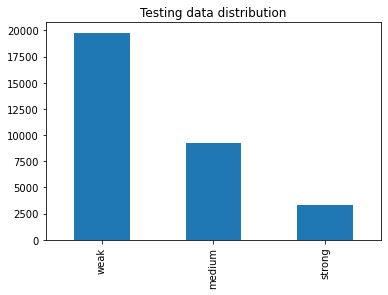

In [8]:
y_test.value_counts().plot(kind='bar')
plt.title('Testing data distribution')
plt.xticks(np.arange(3), ['weak', 'medium', 'strong'])
plt.show()

### BOW approach

In [9]:

bow_vec = CountVectorizer(analyzer='char')

Xtrain_bow = bow_vec.fit_transform(X_train)
Xtest_bow = bow_vec.transform(X_test)

with open('Xtrain.pkl', 'wb') as f :
    pickle.dump(X_train, f)

In [10]:
print('Training Data Shape : ', Xtrain_bow.shape)
print('Testing Data Shape : ', Xtest_bow.shape)


Training Data Shape :  (75297, 96)
Testing Data Shape :  (32271, 96)


### Model 1 : Logistic Regression

In [61]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
    
c_vals = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
accs_lr = []
prec_lr = []
rec_lr = []
f_scores_lr = []

for c in c_vals :
    
    log_reg_bow = LogisticRegression(penalty='l2', multi_class='ovr', max_iter=1000, C=c)
    log_reg_bow.fit(Xtrain_bow, y_train)
    
    

    ytest_bow_pred = log_reg_bow.predict(Xtest_bow)
    
    accs_lr.append(accuracy_score(y_test, ytest_bow_pred))
    f_scores_lr.append(f1_score(y_test, ytest_bow_pred, average='macro'))
    prec_lr.append(precision_score(y_test, ytest_bow_pred, average='macro'))
    rec_lr.append(recall_score(y_test, ytest_bow_pred, average='macro'))
    
    

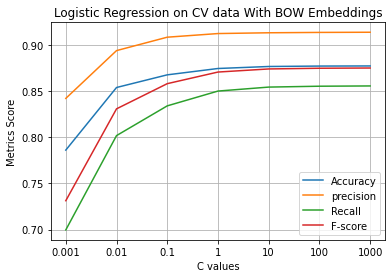

In [85]:
plt.plot(accs_lr, label='Accuracy')
plt.plot(prec_lr, label='precision')
plt.plot(rec_lr, label='Recall')
plt.plot(f_scores_lr, label='F-score')

plt.xticks(np.arange(7), c_vals)
plt.legend(loc='best')
plt.xlabel('C values')
plt.ylabel('Metrics Score')
plt.grid()
plt.title('Logistic Regression on CV data With BOW Embeddings')
plt.show()

###  Best Model with C=1

In [103]:
log_reg_bow = LogisticRegression(penalty='l2', multi_class='ovr', max_iter=1000, C=1)
log_reg_bow.fit(Xtrain_bow, y_train)

ytrain_bow_pred = log_reg_bow.predict(Xtrain_bow)
ytest_bow_pred = log_reg_bow.predict(Xtest_bow)


print('-'*30)
print('Accuracy of Testing data: ', accuracy_score(y_test, ytest_bow_pred))
print('Precision of Testing data: ', precision_score(y_test, ytest_bow_pred, average='macro'))
print('Recall of Testing data: ', recall_score(y_test, ytest_bow_pred, average='macro'))
print('F1 score of Testing data: ', f1_score(y_test, ytest_bow_pred, average='macro'))


------------------------------
Accuracy of Testing data:  0.8745003253695268
Precision of Testing data:  0.9123698504868628
Recall of Testing data:  0.8500370461785409
F1 score of Testing data:  0.8706476547899781


### Model 2 Decision Trees

In [63]:
from sklearn.tree import DecisionTreeClassifier

accs_dt = []
prec_dt = []
rec_dt= []
f_scores_dt = []

for dep in [100, 200, 300, 400, 500] :
    dt_bow = DecisionTreeClassifier(random_state=0, max_depth = dep)
    
    dt_bow.fit(Xtrain_bow, y_train)
    

    ytest_bow_pred = dt_bow.predict(Xtest_bow)
    
    accs_dt.append(accuracy_score(y_test, ytest_bow_pred))
    f_scores_dt.append(f1_score(y_test, ytest_bow_pred, average='macro'))
    prec_dt.append(precision_score(y_test, ytest_bow_pred, average='macro'))
    rec_dt.append(recall_score(y_test, ytest_bow_pred, average='macro'))
    

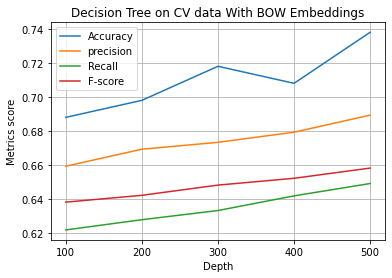

In [84]:
plt.plot(accs_dt, label='Accuracy')
plt.plot(prec_dt, label='precision')

plt.plot(rec_dt, label='Recall')
plt.plot(f_scores_dt, label='F-score')

# plt.xticks(np.arange(6),[100, 200, 300, 400, 500]  )
plt.legend(loc='best')
plt.grid()
plt.xticks([0,1, 2,3, 4], [100, 200, 300, 400, 500] )
plt.xlabel('Depth')
plt.ylabel('Metrics score')
plt.title('Decision Tree on CV data With BOW Embeddings')
plt.show()

### Model 2 : SVM

### Tuning SVM

In [98]:
C_vals = [ 0.01, 0.1, 1, 10, 100]


accs_svm = []
prec_svm = []
rec_svm= []
f_scores_svm = []

for c in C_vals:
    
    svc_bow = SVC(kernel= 'rbf', decision_function_shape='ovr', max_iter=500, C=c)
    svc_bow.fit(Xtrain_bow, y_train)

    ytest_bow_pred = svc_bow.predict(Xtest_bow)
    
    accs_svm.append(accuracy_score(y_test, ytest_bow_pred))
    f_scores_svm.append(f1_score(y_test, ytest_bow_pred, average='macro'))
    prec_svm.append(precision_score(y_test, ytest_bow_pred, average='macro'))
    rec_svm.append(recall_score(y_test, ytest_bow_pred, average='macro'))
    
    

C:\Users\sarat\miniconda3\envs\text\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sarat\miniconda3\envs\text\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sarat\miniconda3\envs\text\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sarat\miniconda3\envs\text\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScale

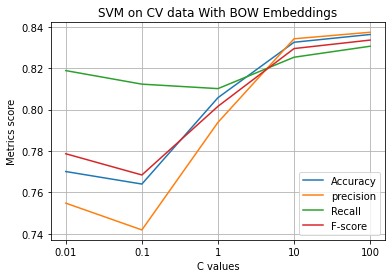

In [97]:
plt.plot(accs_svm, label='Accuracy')
plt.plot(prec_svm, label='precision')

plt.plot(rec_svm, label='Recall')
plt.plot(f_scores_svm, label='F-score')

# plt.xticks(np.arange(6),[100, 200, 300, 400, 500]  )
plt.legend(loc='best')
plt.grid()
plt.xticks([0,1, 2,3, 4],C_vals )
plt.xlabel('C values')
plt.ylabel('Metrics score')
plt.title('SVM on CV data With BOW Embeddings')
plt.show()

In [ ]:

svc_bow = SVC(kernel='rbf', decision_function_shape='ovr', max_iter=1000, probability=True)
svc_bow.fit(Xtrain_bow, y_train)
ytrain_bow_pred = svc_bow.predict(Xtrain_bow)
ytest_bow_pred = svc_bow.predict(Xtest_bow)



In [105]:
print('-'*30)
print('Accuracy of Testing data: ', accuracy_score(y_test, ytest_bow_pred))
print('Precision score of Testing data: ', precision_score(y_test, ytest_bow_pred, average='macro'))
print('Recall of Testing data: ', recall_score(y_test, ytest_bow_pred, average='macro'))
print('F1 score of Testing data: ', f1_score(y_test, ytest_bow_pred, average='macro'))

------------------------------
Accuracy of Testing data:  0.9343063431563943
Precision score of Testing data:  0.927906009109671
Recall of Testing data:  0.9450155668020853
F1 score of Testing data:  0.9356354362561601


In [94]:
import pickle
with open('svm_classifier.pkl', 'wb') as f:
    pickle.dump(svc_bow,f)

In [99]:
with open('svm_classifier.pkl', 'rb') as f :
    clf = pickle.load(f)

In [39]:
with open('bow_vectorizer.pkl', 'wb') as f :
    pickle.dump(bow_vec, f)

### Testing on New data

In [60]:
new_pswds = ['sarath', 's@r@$ddddddd12', 'S2a2th', 'S@3ar1','SSDFaeaefr@#$56d','lamborghin1','qqqqqqqqqqq']
new_pswds_bow = bow_vec.transform(new_pswds)

for pwd, bow in zip(new_pswds, new_pswds_bow) :
    
    lab = dt_bow.predict(bow)
    print(f'New Password : {pwd}, Predcited label : {lab}')
    

New Password : sarath, Predcited label : [0]
New Password : s@r@$ddddddd12, Predcited label : [0]
New Password : S2a2th, Predcited label : [0]
New Password : S@3ar1, Predcited label : [0]
New Password : SSDFaeaefr@#$56d, Predcited label : [0]
New Password : lamborghin1, Predcited label : [1]
New Password : qqqqqqqqqqq, Predcited label : [0]
